# Linear Classification Exercise

In the field of machine learning, the goal of statistical classification is to use an object's characteristics to identify which class (or group) it belongs to. A linear classifier achieves this by making a classification decision based on the value of a linear combination of the characteristics. In detail, linear classifier is designed to predict discrete class labels, or more generally posterior probabilities that lie in the range $(0,1)$. To achieve this, a *generalized linear model* is applied

$$
y(\boldsymbol{x})=f\left(\boldsymbol{w}^{T} \boldsymbol{x}+w_{0}\right)
$$

where $f(\cdot)$ is a fixed non-linear function (a.k.a activate function).

In this way, decision boundary between classes will be linear function of $\boldsymbol{x}$. However, we can also make a fixed non-linear transformation of the input $\boldsymbol{x}$ using a vector of basis functions $\phi(\boldsymbol{x})$. If so, the resulting decision boundaries will be linear in the feature space $\phi$, and these correspond to nonlinear decision boundaries in the
original $\boldsymbol{x}$ space.

> Owing to time constraints, transformation function $\phi(\boldsymbol{x})$ is not adopted in this exercise.

The target of this assignment is to design and implement linear classifiers for [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit classification. Least squares with regularization and logistic regression are required in this exercise.

## Table of Contents

- [1-Packages](#1)
- [2-Load the Dataset](#2)
- [3-Regularized least squares for classification](#3)
- [4-Logistic regression](#4)
  - [4.1-One-vs-rest classification](#4-1)
  - [4.2-Softmax regression](#4-2) 

<a name='1'></a>
## 1 - Packages

First import all the packages needed during this assignment.

In [1]:
import subprocess
import struct
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

<a name='2'></a>
## 2 - Load the Dataset  

In [2]:
remote_url = 'http://yann.lecun.com/exdb/mnist/'
files = ('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
         't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

save_path = 'mnist'
os.makedirs(save_path, exist_ok=True)

# Download MNIST dataset
for file in files:
    data_path = os.path.join(save_path, file)
    if not os.path.exists(data_path):
        url = remote_url + file
        print(f'Downloading {file} from {url}')
        subprocess.call(['wget', '--quiet', '-O', data_path, url])
        print(f'Finish downloading {file}')

# Extract zip files
subprocess.call(f'find {save_path}/ -name "*.gz" | xargs gunzip -f', shell=True);

Finish downloading train-images-idx3-ubyte.gz
Finish downloading train-labels-idx1-ubyte.gz
Finish downloading t10k-images-idx3-ubyte.gz
Finish downloading t10k-labels-idx1-ubyte.gz


In [3]:
mnist_prefixs = ['train_images', 'train_labels', 't10k_images', 't10k_labels']
result = dict.fromkeys(mnist_prefixs)

for file in os.listdir(save_path):
    with open(os.path.join(save_path, file), 'rb') as f:
        prefix = '_'.join(file.split('-')[:2])
        if 'labels' in prefix:
            magic_num, size = struct.unpack('>II', f.read(8))
            result[prefix] = np.fromfile(f, dtype=np.uint8).reshape(size, -1)
        elif 'images' in prefix:
            magic_num, size, rows, cols = struct.unpack('>IIII', f.read(16))
            # reshape to column vector
            result[prefix] = np.fromfile(f, dtype=np.uint8).reshape(size, -1) / 255
        else:
            raise Exception(f'Unexpected filename: {file}')
    
train_img, train_label, test_img, test_label = (result[key] for key in mnist_prefixs)

In [4]:
# As a sanity check, print out the size of the training and test data
print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_label.shape)
print('Test data shape: ', test_img.shape)
print('Test labels shape: ', test_label.shape)

Training data shape:  (60000, 784)
Training labels shape:  (60000, 1)
Test data shape:  (10000, 784)
Test labels shape:  (10000, 1)


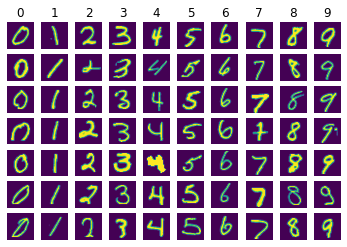

In [5]:
# Visualize some examples from the dataset
classes = list(range(0, 10))
num_classes = len(classes)
sample_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_label == cls)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_per_class, num_classes, plt_idx)
        img_size = int(np.sqrt(train_img[idx].shape[-1]))
        plt.imshow(train_img[idx].reshape(img_size, img_size))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

<a name='3'></a>
## 3 - Regularized least squares for classification

Denote the input data as $\widetilde{\mathbf{W}}$, where $\widetilde{\mathbf{W}}$ is a matrix whose $k^{\text {th}}$ column comprises the $D+1$dimensional vector $\widetilde{\mathbf{w}}_{k}=\left(w_{k 0}, \mathbf{w}_{k}^{\mathrm{T}}\right)^{\mathrm{T}}$ and $\widetilde{\mathrm{x}}$ is the corresponding augmented input vector $\left(1, \mathrm{x}^{\mathrm{T}}\right)^{\mathrm{T}}$ with a dummy input $x_{0}=1$. A new input $\mathrm{x}$ is then assigned to the class for which the output $y_{k}=\widetilde{\mathbf{w}}_{k}^{\mathrm{T}} \widetilde{\mathbf{x}}$ is largest. Furthurmore, define matrix $\mathrm{T}$ whose $n^{\text {th}}$ row is the one-hot vector $\mathbf{t}_{n}^{\mathrm{T}}$, together with a matrix $\widetilde{\mathbf{X}}$ whose $n^{\text {th}}$ row is $\mathbf{x}_{n}^{\mathrm{T}}$. 

The parameter matrix $\widetilde{\mathbf{W}}$ is determined by minimizing a sum-of-squares error function

$$
\begin{aligned}
E(\widetilde{\mathbf{W}}) &=E_{D}(\widetilde{\mathbf{W}})+{\lambda} E_{W}(\widetilde{\mathbf{W}}) \\
&=\frac{1}{2} \operatorname{Tr}\left\{(\widetilde{\mathbf{X}} \widetilde{\mathbf{W}}-\mathbf{T})^{\mathrm{T}}(\widetilde{\mathbf{X}} \widetilde{\mathbf{W}}-\mathbf{T})\right\} + \frac{\lambda}{2} \operatorname{Tr}\left\{\widetilde{\mathbf{W}}\widetilde{\mathbf{W}}^{\mathrm{T}} \right\}
\end{aligned}
$$

which is minimized by

$$
\widetilde{\mathbf{W}}=\left(\tilde{\mathbf{X}}^{\mathrm{T}} \tilde{\mathbf{X}}+\alpha I\right)^{-1} \tilde{\mathbf{X}}^{\mathrm{T}} \mathbf{T}
$$

In [6]:
def to_one_hot(values):
    values = np.squeeze(values)
    n_values = np.max(values) + 1
    return np.eye(n_values)[values]

In [7]:
def get_weights(X, Y, lam):
    A = np.insert(X, 0, 1, axis=1)
    Y = to_one_hot(Y)
    ATA = np.matmul(A.T, A)
    ATA_I = ATA + lam * np.identity(A.shape[1])
    ATA_I_inv = np.linalg.inv(ATA_I)
    ATA_I_inv_AT = np.matmul(ATA_I_inv, A.T)
    weights = np.matmul(ATA_I_inv_AT, Y)
    return weights

In [8]:
def evaluate_accuracy(weights, X, Y):
    X = np.insert(X, 0, 1, axis=1)
    A = np.dot(X, weights)
    pred = np.argmax(A, axis=1).reshape(Y.shape[0], 1)  # assign to class that has highest probability
    accuracy = np.mean(pred == Y)
    return accuracy

In [9]:
weights = get_weights(train_img, train_label, lam=0.2)  # Empirically, set lambda=0.2

# Evaluate accuracy on training set and testing set
print('train accuracy: {:.2f} %'.format(evaluate_accuracy(weights, train_img, train_label) * 100))
print('test accuracy: {:.2f} %'.format(evaluate_accuracy(weights, test_img, test_label) * 100))

train accuracy: 85.76 %
test accuracy: 86.05 %


<a name='4'></a>
## 4 - Logistic regression

In statistics, the logistic model (or logit model) is used to model the probability of a certain class or event existing. In the logistic model, the log-odds (the logarithm of the odds) for the value labeled "1" is a linear combination of one or more independent variables ("predictors"); the independent variables can each be a binary variable (two classes, coded by an indicator variable) or a continuous variable (any real value). The corresponding probability of the value labeled "1" can vary between 0 (certainly the value "0") and 1 (certainly the value "1"), hence the labeling; the function that converts log-odds to probability is the logistic function, hence the name.

<a name='4-1'></a>
### 4.1 - One-vs-rest classification

In this section, we adopted *one-versus-the-rest* strategy for multi-class classification. $10$ classifers, each of which solves a two-class problem of logistic regression, were trained. The $k$th classifer gives the probability $P$ of input $\boldsymbol{x}$ belongs to class $C_{k}$, are the final classification result is given by $\arg \max _{k}P_{k}$

In [10]:
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

In [11]:
num_iterations = 2000
learning_rate = 0.01
classes = np.arange(0, 10)
classifiers = dict()

for class_label in classes:
    X = train_img
    Y = np.where(train_label == class_label, 1, 0)  # One-vs-rest mapping
    
    # TODO: check
    num_examples, dim_input = X.shape
    
    # initialize parameters with zero
    W = np.zeros(shape=(dim_input, 1))
    b = 0 
    
    print('Training classifier %d' % class_label)
    for i in range(1, num_iterations+1):
        # logistic function
        A = sigmoid(np.dot(X, W) + b)

        # cost function
        cost = (-1/num_examples) * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))  # compute cost
        if i % 500 == 0:
            print('Cost after iteration %i: %f' % (i, cost))
            
        # compute gradients
        dW = (1/num_examples) * np.dot(X.T, (A-Y))
        db = (1/num_examples) * np.sum(A-Y)
        
        # gradient descent
        W = W - learning_rate * dW
        b = b - learning_rate * db

    classifiers[class_label] = (W, b)  # record parameters of trained classifiers

Training classifier 0
Cost after iteration 500: 0.107679
Cost after iteration 1000: 0.082289
Cost after iteration 1500: 0.071289
Cost after iteration 2000: 0.064741
Training classifier 1
Cost after iteration 500: 0.098209
Cost after iteration 1000: 0.073553
Cost after iteration 1500: 0.063528
Cost after iteration 2000: 0.057860
Training classifier 2
Cost after iteration 500: 0.172883
Cost after iteration 1000: 0.138926
Cost after iteration 1500: 0.124066
Cost after iteration 2000: 0.115369
Training classifier 3
Cost after iteration 500: 0.180289
Cost after iteration 1000: 0.149211
Cost after iteration 1500: 0.135523
Cost after iteration 2000: 0.127494
Training classifier 4
Cost after iteration 500: 0.159823
Cost after iteration 1000: 0.126487
Cost after iteration 1500: 0.111240
Cost after iteration 2000: 0.102097
Training classifier 5
Cost after iteration 500: 0.205883
Cost after iteration 1000: 0.173515
Cost after iteration 1500: 0.157358
Cost after iteration 2000: 0.147399
Training c

In [12]:
# Evaluate accuracy of each classifier on training set
for class_label in classes:
    W, b = classifiers[class_label]
    A = sigmoid(np.dot(X, W) + b)
    A = np.where(A > 0.5, 1, 0)
    Y = np.where(train_label == class_label, 1, 0)
    accuracy = np.mean(A == Y)
    print('Accuracy of classifier %d: %.4f' % (class_label, accuracy))

Accuracy of classifier 0: 0.9841
Accuracy of classifier 1: 0.9852
Accuracy of classifier 2: 0.9658
Accuracy of classifier 3: 0.9613
Accuracy of classifier 4: 0.9709
Accuracy of classifier 5: 0.9482
Accuracy of classifier 6: 0.9791
Accuracy of classifier 7: 0.9765
Accuracy of classifier 8: 0.9375
Accuracy of classifier 9: 0.9450


In [13]:
def evaluate_accuracy(classifiers, X, Y):
    probabilities = []
    for class_label in classes:
        W, b = classifiers[class_label]
        A = sigmoid(np.dot(X, W) + b)
        probabilities.append(A)
    
    probabilities = np.hstack(probabilities)  # size: num_classes * num_examples
    pred = np.argmax(probabilities, axis=1)  # assign to class that has highest probability
    accuracy = np.mean(pred == Y)
    return accuracy

# Evaluate accuracy on training set and testing set
print('train accuracy: {:.2f} %'.format(evaluate_accuracy(classifiers, train_img, train_label) * 100))
print('test accuracy: {:.2f} %'.format(evaluate_accuracy(classifiers, test_img, test_label) * 100))

train accuracy: 10.06 %
test accuracy: 10.05 %


<a name='4-2'></a>
### 4.2 - Softmax regression

For mutli-class classification, the goal in logistic regression is to estimate the probability of if $\boldsymbol{x}$ belongs to a class $\mathcal{C}_{k}$, or $P\left(\mathcal{C}_{k} \mid \boldsymbol{x}\right)$. Under *Bayes' Theorem*, the posterior probabilities are given by a *softmax* transformation of linear functions of the feature variables, which is

$$
\begin{aligned}
P\left(\mathcal{C}_{k} \mid \boldsymbol{x}\right) &=\frac{P\left(\boldsymbol{x} \mid \mathcal{C}_{k}\right) P\left(\mathcal{C}_{k}\right)}{\sum_{j} P\left(\boldsymbol{x} \mid \mathcal{C}_{j}\right) P\left(\mathcal{C}_{j}\right)} \\
&=\frac{\exp \left(a_{k}\right)}{\sum_{j} \exp \left(a_{j}\right)} \\
\text { where } & a_{k}=\ln P\left(\boldsymbol{x} \mid \mathcal{C}_{k}\right) P\left(\mathcal{C}_{k}\right)
\end{aligned}
$$

Assume the class-conditional densities $P\left(\boldsymbol{x} \mid \mathcal{C}_{k}\right)$ are Gaussians, and have the same covariance matrix $\boldsymbol{\Sigma}$

$$
P\left(\boldsymbol{x} \mid \mathcal{C}_{k}\right)=\frac{1}{(2 \pi)^{D / 2}|\boldsymbol{\Sigma}|^{1 / 2}} \exp \left\{-\frac{1}{2}\left(\boldsymbol{x}-\boldsymbol{\mu}_{k}\right)^{T} \boldsymbol{\Sigma}^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}_{k}\right)\right\}
$$

By substituting $P\left(\boldsymbol{x} \mid \mathcal{C}_{k}\right)$, we can obtain a_{k} as

$$
a_{k}(\boldsymbol{x})=\mathbf{w}_{k}^{\mathrm{T}} \boldsymbol{x}+b_k
$$

where we have defined

$$
\begin{aligned}
\mathbf{w}_{k} &=\boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}_{k} \\
b_k &=-\frac{1}{2} \boldsymbol{\mu}_{k}^{\mathrm{T}} \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}_{k}+\ln p\left(\mathcal{C}_{k}\right)
\end{aligned}
$$

We see that the $a_{k}(\mathbf{x})$ are linear functions of $\mathbf{x}$ as a consequence of the cancellation of the quadratic terms due to the shared covariances. The resulting decision boundaries, corresponding to the minimum misclassification rate, will occur when two of the posterior probabilities (the two largest) are equal, and so will be defined by linear functions of $\mathbf{x}$, **and so we have a generalized linear model.**

For softmax regression, the output of logistic regression is a vector of probabilities for each class. 

$$
\boldsymbol{f}(\mathbf{x} ; \mathbf{W}; \mathbf{b})=\left[\begin{array}{c}
P\left(\mathcal{C}_{1} \mid \boldsymbol{x}; \mathbf{W}; \mathbf{b}\right) \\
P\left(\mathcal{C}_{2} \mid \boldsymbol{x}; \mathbf{W}; \mathbf{b}\right) \\
\vdots \\
P\left(\mathcal{C}_{k} \mid \boldsymbol{x}; \mathbf{W}; \mathbf{b}\right) \\
\end{array}\right]
$$

Using maximum likelihood, optimizing parameters $\left\{\mathbf{w}_{k}, \mathbf{b}_{k}\right\}$ is equivalent to minimising the negative log likelihood:

$$
J(\mathbf{W}; \mathbf{b})=-\sum_{n=1}^{N} \sum_{k=1}^{K} y_{k}^{(n)} \log \frac{\exp \left(\mathbf{w}_{k}^{\mathrm{T}} \boldsymbol{x}+b_k\right)}{\sum_{j} \exp \left(\mathbf{w}_{j}^{\mathrm{T}} \boldsymbol{x}+b_j\right)}
$$


where $y_{k}$ is represented as a *one-hot vector*

$$
\mathbf{y}^{(n)}=\left[\begin{array}{llllllll}
0 & 0 & \ldots & 0 & 1 & 0 & \ldots & 0
\end{array}\right]^{\top}
$$

Taking the gradient of the $J$ with respect to $\mathbf{w}_{k}$ and $b_k$, we obatin

$$
\begin{aligned}
\frac{\partial J(\mathbf{W}; \mathbf{b})}{\partial \mathbf{w}_{k}}&=\sum_{n=1}^{N}\left(f_{k}\left(\mathbf{x}^{(n)} ; \mathbf{W} ; \mathbf{b}\right) - y_{k}^{(n)}\right) \mathbf{x}^{(n)} \\
\frac{\partial J(\mathbf{W}; \mathbf{b})}{\partial b_{k}}&=\sum_{n=1}^{N}\left(f_{k}\left(\mathbf{x}^{(n)} ; \mathbf{W} ; \mathbf{b}\right) - y_{k}^{(n)}\right)
\end{aligned}
$$

Using these derivatives, we can minimize the loss using *gradient descent*

In [14]:
def softmax(X):
    X_exp = np.exp(X)
    partition = np.sum(X_exp, axis=1, keepdims=True)
    return X_exp / partition

In [15]:
num_iterations = 2000
learning_rate = 0.01

X = train_img
Y = to_one_hot(train_label)

num_examples, dim_input = X.shape
_, dim_output = Y.shape

# initialize parameters with zero
W = np.zeros(shape=(dim_input, dim_output))
b = np.zeros(shape=(1, dim_output))

for i in range(1, num_iterations+1):
    # logistic function
    A = softmax(np.dot(X, W) + b)
    
    # cost function
    cost = (-1/num_examples) * np.sum(Y * np.log(A))  # compute cost
    if i % 500 == 0:
        print('Cost after iteration %i: %f' % (i, cost))

    # compute gradients
    dW = (1/num_examples) * np.dot(X.T, (A-Y))
    db = (1/num_examples) * np.sum(A-Y)

    # gradient descent
    W = W - learning_rate * dW
    b = b -learning_rate * db
    
classifier = W, b

Cost after iteration 500: 0.801738
Cost after iteration 1000: 0.612346
Cost after iteration 1500: 0.535692
Cost after iteration 2000: 0.492483


In [16]:
def evaluate_accuracy(classifier, X, Y):
    probabilities = []
    W, b = classifier
    A = softmax(np.dot(X, W) + b)  # size: num_classes * num_examples
    pred = np.argmax(A, axis=1)  # assign to class that has highest probability
    accuracy = np.mean(pred == Y)
    return accuracy

# Evaluate accuracy on training set and testing set
print('train accuracy: {:.2f} %'.format(evaluate_accuracy(classifier, train_img, train_label) * 100))
print('test accuracy: {:.2f} %'.format(evaluate_accuracy(classifier, test_img, test_label) * 100))

train accuracy: 10.05 %
test accuracy: 10.05 %
